# Disentanglement: When does a model rely on memory vs. reasoning?

Goal: Design prompts that require either recall (factual memory) or reasoning (multi-step logic), and analyze the model’s responses and activations.

### Setup

In [ ]:
!pip install nnsight==0.4.5 transformers==4.47.1 torch --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from nnsight import LanguageModel
from transformers import AutoTokenizer
import torch

## Load model and analyze

In [ ]:
model_name = "Qwen/Qwen2.5-7B-Instruct"
model = LanguageModel(model_name, device_map="cuda", torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
prompt = 'If X is the capital of France, then X is'
n_new_tokens = 64
layer1_output = None
with model.generate(prompt, max_new_tokens=n_new_tokens) as tracer:
    out = model.generator.output.save()
    layer1_output = model.model.layers[0].output.save()
    layer2_output = model.model.layers[1].output.save()

print(layer1_output)
decoded_prompt = model.tokenizer.decode(out[0][0:-n_new_tokens].cpu())
decoded_answer = model.tokenizer.decode(out[0][-n_new_tokens:].cpu())

print("Prompt: ", decoded_prompt)
print("Generated Answer: ", decoded_answer)

(tensor([[[-0.0879, -0.1680,  0.0608,  ...,  0.1099, -0.0264, -0.4336],
         [-0.1328, -0.0693,  0.0190,  ..., -0.0024,  0.0093,  0.1289],
         [ 0.0879,  0.2695, -0.0212,  ...,  0.0781,  0.1465, -0.0317],
         ...,
         [ 0.0342, -0.0056,  0.0503,  ...,  0.4512,  0.1182, -0.0991],
         [-0.1147, -0.0281, -0.2539,  ...,  0.0613,  0.0200, -0.0034],
         [ 0.1074,  0.0566,  0.0405,  ...,  0.1025,  0.1338, -0.0498]]],
       device='cuda:0', dtype=torch.bfloat16), DynamicCache())
Prompt:  If X is the capital of France, then X is
Generated Answer:   Paris. Given that X is not Paris, what can we conclude about X being the capital of France? If \( X \) is the capital of France, then \( X \) is Paris. This statement establishes a direct equivalence: if \( X \) is the capital of France, it must be Paris.

Given


In [ ]:
layer1_output

(tensor([[[-0.1924,  0.1118, -0.4766,  ..., -0.3965, -0.7695, -0.4453],
          [-0.1387,  0.1206, -0.0605,  ...,  0.0625,  0.3105,  0.1367],
          [ 0.1099,  0.2109, -0.3027,  ...,  0.0454, -0.6836, -0.0664],
          ...,
          [ 0.0559, -0.0342,  0.0013,  ...,  0.0073, -0.1074,  0.1250],
          [-0.0513,  0.0344,  0.1191,  ...,  0.0869,  0.1689, -0.0403],
          [ 0.2949,  0.2148,  0.1504,  ..., -0.0791,  0.0280,  0.1021]]],
        device='cuda:0', dtype=torch.bfloat16),
 DynamicCache())

In [ ]:
prompts = [
    ("recall", "The capital of France is"),
    ("recall", "The capital of Germany is"),
    ("recall", "The capital of Japan is"),
    ("recall", "France is located in"),
    ("recall", "The currency of France is the"),

    ("reasoning", "If X is the capital of France, then X is"),
    ("reasoning", "If A is the capital of B, and B is Germany, then A is"),
    ("reasoning", "If Y is the capital of Z, and Z is Japan, then Y is"),
    ("reasoning", "If country C is in Europe and C is France, then France is in"),
    ("reasoning", "If nation N uses currency E, and N is France, then France uses the"),

    ("two_hop_reasoning", "If Paris is the capital of France, and France is in Europe, then Paris is in"),
    ("two_hop_reasoning", "If Berlin is the capital of Germany, and Germany uses the Euro, then Berlin is in a country that uses the"),
    ("two_hop_reasoning", "If Tokyo is the capital of Japan, and Japan is in Asia, then Tokyo is in"),
    ("two_hop_reasoning", "If the Euro is the currency of France, and France is a country in Europe, then the Euro is used in"),
    ("two_hop_reasoning", "If Yen is the currency of Japan, and Japan is in Asia, then the Yen is used in a country in"),
    ("two_hop_reasoning", "If A is the capital of B, and B is in Europe, then A is the capital of a country in"),
    ("two_hop_reasoning", "If X is the currency of Y, and Y is France, then X is used in"),
    ("two_hop_reasoning", "If M is the capital of N, and N uses currency C, then M is in a country that uses"),


    ("three_hop_reasoning", "If Paris is the capital of France, France is in Europe, and Europe is a continent, then Paris is in a country on the"),
    ("three_hop_reasoning", "If Berlin is the capital of Germany, Germany uses the Euro, and the Euro is a currency of Europe, then Berlin is in a country that uses a currency of"),
    ("three_hop_reasoning", "If Tokyo is the capital of Japan, Japan is in Asia, and Asia is a continent, then Tokyo is in a country on the"),
    ("three_hop_reasoning", "If France uses the Euro, France is in Europe, and Europe is north of Africa, then France is in a region north of"),
    ("three_hop_reasoning", "If the Yen is used in Japan, Japan is in Asia, and Asia contains Japan, then the Yen is a currency used in a country that is in"),
    ("three_hop_reasoning", "If A is the capital of B, B uses currency C, and B is France, then A is the capital of a country that uses"),
    ("three_hop_reasoning", "If X is the currency of Y, Y is located in Z, and Z is Europe, then X is used in a country in"),
    ("three_hop_reasoning", "If M is the capital of N, N is in P, and P is Europe, then M is the capital of a country in"),


    ("four_hop_reasoning", "If A is the capital of B, B uses currency C, B is in D, and D is Europe, then A is the capital of a country in"),
    ("four_hop_reasoning", "If X is the currency of Y, Y is located in Z, Z is part of W, and W is Europe, then X is used in a country in"),
    ("four_hop_reasoning", "If M is the capital of N, N uses currency P, N is in Q, and Q is Europe, then M is the capital of a country in"),
    ("four_hop_reasoning", "If R is the capital of S, S uses currency T, S is located in U, and U is Europe, then R is the capital of a European country that uses"),
]

### Fix: Activation tracing

In [ ]:
prompts = [
    ("recall", "The Eiffel Tower is in the city of")
]

In [ ]:
activations = []
responses = []
layer_output = None
for label, prompt in prompts:
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    with model.trace({"input_ids": inputs["input_ids"]}) as tracer:
        saved_acts = []
        print(model.config.num_hidden_layers)
        for i in range(model.config.num_hidden_layers):
            # Save the output of the whole transformer block
            #layer_output = model.model.layers[i].output.save()
            saved_acts.append(model.model.layers[i].output.save())

    print(saved_acts[0])


28
(tensor([[[-0.1924,  0.1118, -0.4766,  ..., -0.3965, -0.7695, -0.4453],
         [-0.1387,  0.1206, -0.0605,  ...,  0.0625,  0.3105,  0.1367],
         [ 0.1099,  0.2109, -0.3027,  ...,  0.0454, -0.6836, -0.0664],
         ...,
         [ 0.0559, -0.0342,  0.0013,  ...,  0.0073, -0.1074,  0.1250],
         [-0.0513,  0.0344,  0.1191,  ...,  0.0869,  0.1689, -0.0403],
         [ 0.2949,  0.2148,  0.1504,  ..., -0.0791,  0.0280,  0.1021]]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<AddBackward0>), DynamicCache())


In [ ]:
saved_acts[0]

(tensor([[[-0.1924,  0.1118, -0.4766,  ..., -0.3965, -0.7695, -0.4453],
         [-0.1387,  0.1206, -0.0605,  ...,  0.0625,  0.3105,  0.1367],
         [ 0.1099,  0.2109, -0.3027,  ...,  0.0454, -0.6836, -0.0664],
         ...,
         [ 0.0559, -0.0342,  0.0013,  ...,  0.0073, -0.1074,  0.1250],
         [-0.0513,  0.0344,  0.1191,  ...,  0.0869,  0.1689, -0.0403],
         [ 0.2949,  0.2148,  0.1504,  ..., -0.0791,  0.0280,  0.1021]]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<AddBackward0>), DynamicCache())

In [ ]:
layer1_output[0]

tensor([[[-0.1924,  0.1118, -0.4766,  ..., -0.3965, -0.7695, -0.4453],
         [-0.1387,  0.1206, -0.0605,  ...,  0.0625,  0.3105,  0.1367],
         [ 0.1099,  0.2109, -0.3027,  ...,  0.0454, -0.6836, -0.0664],
         ...,
         [ 0.0559, -0.0342,  0.0013,  ...,  0.0073, -0.1074,  0.1250],
         [-0.0513,  0.0344,  0.1191,  ...,  0.0869,  0.1689, -0.0403],
         [ 0.2949,  0.2148,  0.1504,  ..., -0.0791,  0.0280,  0.1021]]],
       device='cuda:0', dtype=torch.bfloat16)

In [ ]:
torch.equal(saved_acts[0][0], layer1_output[0])

True

In [ ]:
prompts

[('recall', 'What is the capital of France?'),
 ('recall', "Who wrote 'Pride and Prejudice'?"),
 ('reasoning',
  'If you have 3 apples and get 2 more, how many apples do you have?'),
 ('reasoning',
  'If John is taller than Mary and Mary is taller than Sue, who is the tallest?')]

In [ ]:
def collect_activations(model, tokenizer, prompts):
    collected_data = []

    for label, prompt in prompts:
        output = None
        inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
        with model.trace({"input_ids": inputs["input_ids"]}) as tracer:
            saved_acts = []
            for i in range(model.config.num_hidden_layers):
                saved_acts.append(model.model.layers[i].output.save())
            output = model(**inputs)

        layer_activations = [act.value for act in saved_acts]
        #output_text = tokenizer.decode(output[0], skip_special_tokens=True)
        collected_data.append({
            'label': label,
            'prompt': prompt,
            #'output': output_text,
            'activations': layer_activations,
            'input_ids': inputs["input_ids"]
        })
    return collected_data


In [ ]:
collected_data = collect_activations(model, tokenizer, prompts)


In [ ]:
collected_data[0]

{'label': 'recall',
 'prompt': 'What is the capital of France?',
 'activations': [(tensor([[[-0.3711,  0.6719, -0.2256,  ...,  0.1235,  0.2832, -0.4844],
            [ 0.1406, -0.3281,  0.4668,  ...,  0.0835, -0.2100, -0.1777],
            [-0.0620,  0.0035,  0.2178,  ...,  0.1416, -0.0693,  0.2031],
            ...,
            [-0.1934,  0.1816,  0.0996,  ...,  0.0605, -0.1094, -0.0059],
            [ 0.1221,  0.1641,  0.2969,  ..., -0.1079,  0.0605, -0.0300],
            [ 0.0801, -0.0386, -0.0242,  ...,  0.4785, -0.0190, -0.0508]]],
          device='cuda:0', dtype=torch.bfloat16, grad_fn=<AddBackward0>),
   DynamicCache()),
  (tensor([[[-0.2021,  0.4043, -0.3789,  ..., -0.0752,  0.2256, -0.7656],
            [ 0.1309, -0.6328,  0.4219,  ...,  0.0640,  0.0420, -0.3105],
            [ 0.0388, -0.2490, -0.0605,  ...,  0.2520,  0.0601,  0.1523],
            ...,
            [-0.1406,  0.1924, -0.0034,  ..., -0.0415, -0.0391, -0.2354],
            [ 0.3750,  0.4043,  0.2041,  ..., -0.3

In [ ]:
print(model)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 3584)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=3584, out_features=3584, bias=True)
          (k_proj): Linear(in_features=3584, out_features=512, bias=True)
          (v_proj): Linear(in_features=3584, out_features=512, bias=True)
          (o_proj): Linear(in_features=3584, out_features=3584, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=3584, out_features=18944, bias=False)
          (up_proj): Linear(in_features=3584, out_features=18944, bias=False)
          (down_proj): Linear(in_features=18944, out_features=3584, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
      )
    )
    (norm):

## Fix above activation collection that is erroring out to access output prediction.

**Use HuggingFace Model for Generation, nnsight for Tracing**

In [ ]:
prompts

[('recall', 'What is the capital of France?'),
 ('recall', "Who wrote 'Pride and Prejudice'?"),
 ('reasoning',
  'If you have 3 apples and get 2 more, how many apples do you have?'),
 ('reasoning',
  'If John is taller than Mary and Mary is taller than Sue, who is the tallest?')]

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from nnsight import LanguageModel

model_name = "Qwen/Qwen2.5-7B-Instruct"

# HuggingFace model for generation
tokenizer = AutoTokenizer.from_pretrained(model_name)
hf_model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype="auto").to("cuda")


ModuleNotFoundError: No module named 'nnsight'

In [ ]:
def collect_activations_and_output(model, hf_model, tokenizer, prompts):
    collected_data = []
    for label, prompt in prompts:
        # 1. Generate output
        inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
        generated_ids = hf_model.generate(
            inputs["input_ids"],
            max_new_tokens=32,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )
        output_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

        # 2. Collect activations for the prompt
        with model.trace({"input_ids": inputs["input_ids"]}) as tracer:
            saved_acts = []
            for i in range(model.config.num_hidden_layers):
                saved_acts.append(model.model.layers[i].output.save())
            _ = model(**inputs)
        layer_activations = [act.value for act in saved_acts]

        collected_data.append({
            'label': label,
            'prompt': prompt,
            'output': output_text,
            'activations': layer_activations,
            'input_ids': inputs["input_ids"]
        })
    return collected_data

In [ ]:
collected_data = collect_activations_and_output(model, hf_model, tokenizer, prompts)


In [ ]:
# Print results
for item in collected_data:
    print(f"Label: {item['label']}")
    print(f"Prompt: {item['prompt']}")
    print(f"Output: {item['output']}\n")
    item['activations'] = [a[0] if isinstance(a, tuple) else a for a in item['activations']]
    print(f"Activations: {item['activations']}\n")

Label: recall
Prompt: What is the capital of France?
Output: What is the capital of France? The capital of France is Paris. 

Paris is a city located in northern France on the Seine River and is known for its rich history, culture, art

Activations: [tensor([[[-0.3711,  0.6719, -0.2256,  ...,  0.1235,  0.2832, -0.4844],
         [ 0.1406, -0.3281,  0.4668,  ...,  0.0835, -0.2100, -0.1777],
         [-0.0620,  0.0035,  0.2178,  ...,  0.1416, -0.0693,  0.2031],
         ...,
         [-0.1934,  0.1816,  0.0996,  ...,  0.0605, -0.1094, -0.0059],
         [ 0.1221,  0.1641,  0.2969,  ..., -0.1079,  0.0605, -0.0300],
         [ 0.0801, -0.0386, -0.0242,  ...,  0.4785, -0.0190, -0.0508]]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<AddBackward0>), tensor([[[-0.2021,  0.4043, -0.3789,  ..., -0.0752,  0.2256, -0.7656],
         [ 0.1309, -0.6328,  0.4219,  ...,  0.0640,  0.0420, -0.3105],
         [ 0.0388, -0.2490, -0.0605,  ...,  0.2520,  0.0601,  0.1523],
         ...,
         

In [ ]:
print(type(collected_data[0]['activations']))           # Should be <class 'list'>
print(type(collected_data[0]['activations'][0]))        # Should be <class 'torch.Tensor'>
print(collected_data[0]['activations'][0].shape)

<class 'list'>
<class 'torch.Tensor'>
torch.Size([1, 7, 3584])


## Analyse layer differences

In [ ]:
import numpy as np
from scipy import stats

def analyze_layer_differences(recall_data, reasoning_data):
    recall_activations = [item['activations'] for item in recall_data]
    reasoning_activations = [item['activations'] for item in reasoning_data]
    num_layers = len(recall_activations[0])
    layer_differences = {}
    for layer_idx in range(num_layers):
        recall_layer_acts = []
        reasoning_layer_acts = []
        for acts in recall_activations:
            layer_act = acts[layer_idx].detach().cpu().to(torch.float32).numpy()
            if len(layer_act.shape) == 3:
                layer_act = np.mean(layer_act, axis=(0, 1))
            elif len(layer_act.shape) == 2:
                layer_act = np.mean(layer_act, axis=0)
            recall_layer_acts.append(layer_act)
        for acts in reasoning_activations:
            layer_act = acts[layer_idx].detach().cpu().to(torch.float32).numpy()
            if len(layer_act.shape) == 3:
                layer_act = np.mean(layer_act, axis=(0, 1))
            elif len(layer_act.shape) == 2:
                layer_act = np.mean(layer_act, axis=0)
            reasoning_layer_acts.append(layer_act)
        recall_array = np.array(recall_layer_acts)
        reasoning_array = np.array(reasoning_layer_acts)
        layer_differences[layer_idx] = {
            'mean_recall': np.mean(recall_array, axis=0),
            'mean_reasoning': np.mean(reasoning_array, axis=0),
            'l2_distance': np.linalg.norm(np.mean(reasoning_array, axis=0) - np.mean(recall_array, axis=0)),
            'cosine_distance': 1 - np.dot(np.mean(recall_array, axis=0), np.mean(reasoning_array, axis=0)) /
                              (np.linalg.norm(np.mean(recall_array, axis=0)) * np.linalg.norm(np.mean(reasoning_array, axis=0))),
            'p_value': stats.ttest_ind(recall_array, reasoning_array, axis=0).pvalue
        }
    return layer_differences



In [ ]:
# Split collected data by label
recall_data = [item for item in collected_data if item['label'] == 'recall']
reasoning_data = [item for item in collected_data if item['label'] == 'reasoning']

layer_differences = analyze_layer_differences(recall_data, reasoning_data)

In [ ]:
print(layer_differences)

{0: {'mean_recall': array([-0.05406494,  0.0779541 ,  0.07756697, ...,  0.0879255 ,
        0.07916608, -0.11207929], dtype=float32), 'mean_reasoning': array([ 0.03690932,  0.02901972,  0.04061408, ..., -0.00398513,
        0.09567572, -0.10724422], dtype=float32), 'l2_distance': np.float32(5.337794), 'cosine_distance': np.float32(0.120810986), 'p_value': array([0.22431161, 0.39580252, 0.60702613, ..., 0.0778228 , 0.86573156,
       0.94301972])}, 1: {'mean_recall': array([-0.03593401,  0.07167097,  0.01259417, ...,  0.0265128 ,
        0.03456683, -0.19015417], dtype=float32), 'mean_reasoning': array([ 0.03922455, -0.01247562,  0.01052981, ..., -0.15716392,
        0.11567803, -0.07120233], dtype=float32), 'l2_distance': np.float32(8.851096), 'cosine_distance': np.float32(0.08748633), 'p_value': array([0.49636823, 0.26801693, 0.93902635, ..., 0.00681433, 0.02529192,
       0.11851225])}, 2: {'mean_recall': array([-0.01017194,  0.0552403 , -0.08555734, ..., -0.00790144,
       -0.02616

## Identify Decision Layers

In [ ]:
def identify_decision_layers(layer_differences, threshold=0.05):
    decision_layers = []
    for layer_idx, metrics in layer_differences.items():
        significant_dims = np.sum(metrics['p_value'] < threshold)
        total_dims = len(metrics['p_value'])
        if significant_dims / total_dims > 0.1:  # e.g., >10% of dims are significant
            decision_layers.append(layer_idx)
    return decision_layers



In [ ]:
decision_layers = identify_decision_layers(layer_differences)
print("Decision layers (most different between recall and reasoning):", decision_layers)

Decision layers (most different between recall and reasoning): [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15]


## Visualize

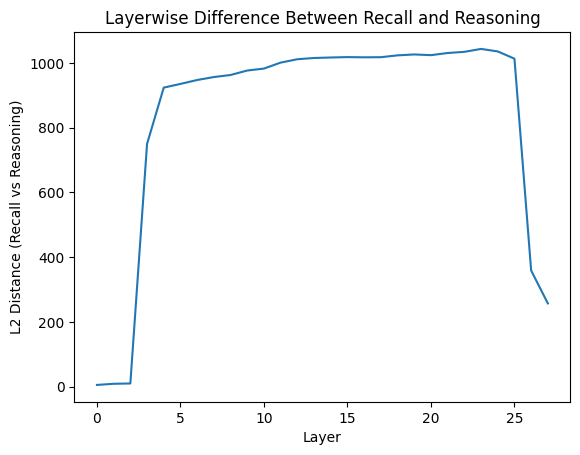

In [ ]:
import matplotlib.pyplot as plt

l2s = [layer_differences[i]['l2_distance'] for i in range(len(layer_differences))]
plt.plot(l2s)
plt.xlabel("Layer")
plt.ylabel("L2 Distance (Recall vs Reasoning)")
plt.title("Layerwise Difference Between Recall and Reasoning")
plt.show()

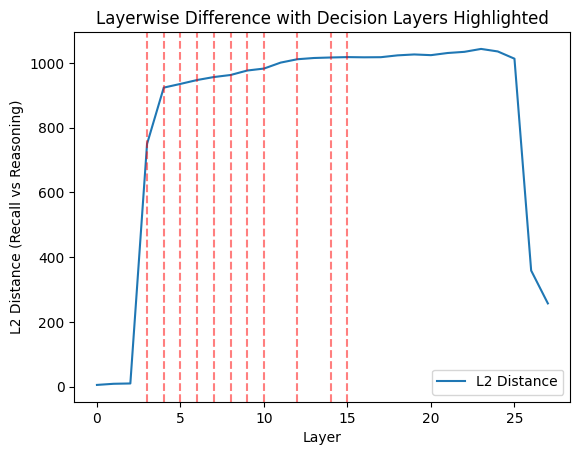

In [ ]:
l2s = [layer_differences[i]['l2_distance'] for i in range(len(layer_differences))]
plt.plot(l2s, label="L2 Distance")
for layer in decision_layers:
    plt.axvline(layer, color='red', linestyle='--', alpha=0.5)
plt.xlabel("Layer")
plt.ylabel("L2 Distance (Recall vs Reasoning)")
plt.title("Layerwise Difference with Decision Layers Highlighted")
plt.legend()
plt.show()

# Revision

In [ ]:
!pip install nnsight==0.4.5 transformers==4.47.1 torch --quiet

In [ ]:
from nnsight import LanguageModel
from transformers import AutoTokenizer
import torch

In [ ]:
model_name = "Qwen/Qwen2.5-7B-Instruct"
model = LanguageModel(model_name, device_map="cuda", torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
prompts = [
    ("recall", "The capital of France is?"),
    ("recall", "The capital of Germany is?"),
    ("recall", "The capital of Japan is?"),
    ("recall", "France is located in?"),
    ("recall", "The currency of France is the?"),

    ("reasoning", "If X is the capital of France, then X is?"),
    ("reasoning", "If A is the capital of B, and B is Germany, then A is?"),
    ("reasoning", "If Y is the capital of Z, and Z is Japan, then Y is?"),
    ("reasoning", "If country C is in Europe and C is France, then France is in?"),
    ("reasoning", "If nation N uses currency E, and N is France, then France uses the?"),

    ("two_hop_reasoning", "If Paris is the capital of France, and France is in Europe, then Paris is in?"),
    ("two_hop_reasoning", "If Berlin is the capital of Germany, and Germany uses the Euro, then Berlin is in a country that uses the?"),
    ("two_hop_reasoning", "If Tokyo is the capital of Japan, and Japan is in Asia, then Tokyo is in?"),
    ("two_hop_reasoning", "If the Euro is the currency of France, and France is a country in Europe, then the Euro is used in?"),
    ("two_hop_reasoning", "If Yen is the currency of Japan, and Japan is in Asia, then the Yen is used in a country in?"),
    ("two_hop_reasoning", "If A is the capital of B, and B is in Europe, then A is the capital of a country in?"),
    ("two_hop_reasoning", "If X is the currency of Y, and Y is France, then X is used in?"),
    ("two_hop_reasoning", "If M is the capital of N, and N uses currency C, then M is in a country that uses?"),


    ("three_hop_reasoning", "If Paris is the capital of France, France is in Europe, and Europe is a continent, then Paris is in a country on the?"),
    ("three_hop_reasoning", "If Berlin is the capital of Germany, Germany uses the Euro, and the Euro is a currency of Europe, then Berlin is in a country that uses a currency of?"),
    ("three_hop_reasoning", "If Tokyo is the capital of Japan, Japan is in Asia, and Asia is a continent, then Tokyo is in a country on the?"),
    ("three_hop_reasoning", "If France uses the Euro, France is in Europe, and Europe is north of Africa, then France is in a region north of?"),
    ("three_hop_reasoning", "If the Yen is used in Japan, Japan is in Asia, and Asia contains Japan, then the Yen is a currency used in a country that is in?"),
    ("three_hop_reasoning", "If A is the capital of B, B uses currency C, and B is France, then A is the capital of a country that uses?"),
    ("three_hop_reasoning", "If X is the currency of Y, Y is located in Z, and Z is Europe, then X is used in a country in?"),
    ("three_hop_reasoning", "If M is the capital of N, N is in P, and P is Europe, then M is the capital of a country in?")
]

In [ ]:
def collect_activations(model, prompts, n_new_tokens=10):
    collected_data = []

    for label, prompt in prompts:
        with model.generate(prompt, max_new_tokens=n_new_tokens) as tracer:
            out = model.generator.output.save()
            saved_acts = []
            for i in range(model.config.num_hidden_layers):
                saved_acts.append(model.model.layers[i].output.save())

        # After the context, extract the actual tensors from the proxies
        layer_activations = []
        for act in saved_acts:
            value = act.value
            # If value is a tuple (tensor, DynamicCache), take the first element
            if isinstance(value, tuple):
                value = value[0]
            layer_activations.append(value)

        # Decode prompt and generated text
        decoded_prompt = model.tokenizer.decode(out[0][0:-n_new_tokens].cpu())
        decoded_answer = model.tokenizer.decode(out[0][-n_new_tokens:].cpu())

        collected_data.append({
            'label': label,
            'prompt': decoded_prompt,
            'generated': decoded_answer,
            'activations': layer_activations
        })

    return collected_data


In [ ]:
collected_data = collect_activations(model, prompts)

In [ ]:
collected_data[0]

{'label': 'recall',
 'prompt': 'The capital of France is?',
 'generated': ' The capital of France is Paris. \n\nParis is',
 'activations': [tensor([[[-0.1924,  0.1118, -0.4766,  ..., -0.3965, -0.7695, -0.4453],
           [-0.0291,  0.2773,  0.4043,  ..., -0.0791, -0.0311,  0.1123],
           [-0.2969,  0.4395,  0.3633,  ...,  0.0898, -0.3398,  0.0732],
           [ 0.1299,  0.2637,  0.3281,  ..., -0.1270,  0.0503, -0.0737],
           [ 0.1050,  0.0192,  0.0278,  ...,  0.0884,  0.1807, -0.2910],
           [ 0.0034,  0.0723, -0.0645,  ...,  0.3809,  0.0503,  0.0684]]],
         device='cuda:0', dtype=torch.bfloat16),
  tensor([[[ 0.0469, -0.0732, -0.5938,  ..., -0.3828, -0.7617, -0.7109],
           [ 0.1128,  0.3555,  0.3438,  ..., -0.4199, -0.2021, -0.1816],
           [-0.3262,  0.5039,  0.3320,  ..., -0.1582, -0.1094, -0.1445],
           [ 0.4121,  0.4961,  0.2793,  ..., -0.3672, -0.2090, -0.2891],
           [-0.0261, -0.0923, -0.0518,  ...,  0.1240,  0.2051, -0.2363],
        

In [ ]:
# Print results
for item in collected_data:
    print(f"Label: {item['label']}")
    print(f"Prompt: {item['prompt']}")
    print(f"Output: {item['generated']}\n")

Label: recall
Prompt: The capital of France is
Output:  Paris. Which of the following options correctly expresses this

Label: recall
Prompt: The capital of Germany is
Output:  a city with a rich history and cultural heritage.

Label: recall
Prompt: The capital of Japan is
Output:  Tokyo, a city with over 13 million

Label: recall
Prompt: France is located in
Output:  Western Europe and borders the Atlantic Ocean and the Mediterranean

Label: recall
Prompt: The currency of France is the
Output:  Euro. It is the official currency in 1

Label: reasoning
Prompt: If X is the capital of France, then X is
Output:  Paris. Given this statement, which of the following

Label: reasoning
Prompt: If A is the capital of B, and B is Germany, then A is
Output:  the capital of Germany. This is a type of

Label: reasoning
Prompt: If Y is the capital of Z, and Z is Japan, then Y is
Output:  Tokyo. Now, if W is the capital of

Label: reasoning
Prompt: If country C is in Europe and C is France, then Franc

In [ ]:
# Print results
for item in collected_data:
    print(f"Label: {item['label']}")
    print(f"Prompt: {item['prompt']}")
    print(f"Output: {item['generated']}\n")

Label: recall
Prompt: The capital of France is
Output:  Paris, and the capital of Italy is Rome.

Label: recall
Prompt: The capital of Germany is
Output:  Berlin, and the capital of France is Paris.

Label: recall
Prompt: The capital of Japan is
Output:  Tokyo. It is located in the eastern part of

Label: recall
Prompt: France is located in
Output:  which continent? France is located in Europe. Specifically

Label: recall
Prompt: The currency of France is the
Output:  euro (€). The euro is divided into 

Label: reasoning
Prompt: If X is the capital of France, then X is
Output:  Paris. Using this same logic, if Y is

Label: reasoning
Prompt: If A is the capital of B, and B is Germany, then A is
Output:  the capital of Germany. This is an example of

Label: reasoning
Prompt: If Y is the capital of Z, and Z is Japan, then Y is
Output:  Tokyo. Now, if X is the capital of

Label: reasoning
Prompt: If country C is in Europe and C is France, then France is in
Output:  Europe.
To solve the pro

In [ ]:
import numpy as np
from scipy import stats
import torch

def analyze_layer_differences(recall_data, reasoning_data):
    recall_activations = [item['activations'] for item in recall_data]
    reasoning_activations = [item['activations'] for item in reasoning_data]
    num_layers = len(recall_activations[0])
    layer_differences = {}
    for layer_idx in range(num_layers):
        recall_layer_acts = []
        reasoning_layer_acts = []
        for acts in recall_activations:
            layer_act = acts[layer_idx]
            # Ensure tensor, detach, move to cpu, convert to float32, then numpy
            if isinstance(layer_act, torch.Tensor):
                arr = layer_act.detach().cpu().to(torch.float32).numpy()
            else:
                raise ValueError("Activation is not a tensor!")
            # Average across batch and sequence if needed
            if len(arr.shape) == 3:
                arr = np.mean(arr, axis=(0, 1))
            elif len(arr.shape) == 2:
                arr = np.mean(arr, axis=0)
            recall_layer_acts.append(arr)
        for acts in reasoning_activations:
            layer_act = acts[layer_idx]
            if isinstance(layer_act, torch.Tensor):
                arr = layer_act.detach().cpu().to(torch.float32).numpy()
            else:
                raise ValueError("Activation is not a tensor!")
            if len(arr.shape) == 3:
                arr = np.mean(arr, axis=(0, 1))
            elif len(arr.shape) == 2:
                arr = np.mean(arr, axis=0)
            reasoning_layer_acts.append(arr)
        recall_array = np.array(recall_layer_acts)
        reasoning_array = np.array(reasoning_layer_acts)
        # Compute metrics
        mean_recall = np.mean(recall_array, axis=0)
        mean_reasoning = np.mean(reasoning_array, axis=0)
        l2_distance = np.linalg.norm(mean_reasoning - mean_recall)
        cosine_distance = 1 - np.dot(mean_recall, mean_reasoning) / (
            np.linalg.norm(mean_recall) * np.linalg.norm(mean_reasoning)
        )
        p_value = stats.ttest_ind(recall_array, reasoning_array, axis=0).pvalue
        layer_differences[layer_idx] = {
            'mean_recall': mean_recall,
            'mean_reasoning': mean_reasoning,
            'l2_distance': l2_distance,
            'cosine_distance': cosine_distance,
            'p_value': p_value
        }
    return layer_differences

In [ ]:
# Split collected data by label
recall_data = [item for item in collected_data if item['label'] == 'recall']
reasoning_data = [item for item in collected_data if item['label'] == 'reasoning']

layer_differences = analyze_layer_differences(recall_data, reasoning_data)

In [ ]:
layer_differences

{0: {'mean_recall': array([ 0.01125767,  0.1256328 ,  0.02225783, ...,  0.00998407,
         -0.12792353, -0.12810896], dtype=float32),
  'mean_reasoning': array([ 0.00608886,  0.05699074,  0.05541163, ...,  0.11656853,
          0.0281425 , -0.04508739], dtype=float32),
  'l2_distance': np.float32(5.965908),
  'cosine_distance': np.float32(0.09599507),
  'p_value': array([9.35004262e-01, 1.11513495e-01, 5.62197409e-01, ...,
         1.05553668e-04, 2.98845002e-04, 4.00179648e-02])},
 1: {'mean_recall': array([ 0.06372164,  0.07289016, -0.06076544, ..., -0.08544178,
         -0.12114211, -0.23830357], dtype=float32),
  'mean_reasoning': array([ 0.01495485, -0.00965597,  0.02785082, ...,  0.0677784 ,
          0.04057477, -0.15937153], dtype=float32),
  'l2_distance': np.float32(11.513238),
  'cosine_distance': np.float32(0.0729925),
  'p_value': array([0.59226514, 0.18989458, 0.14545005, ..., 0.00227731, 0.00118518,
         0.00407178])},
 2: {'mean_recall': array([ 0.10946102,  0.162

**L2 Distance	measures magnitude of difference helpful for finding decision layers. High values means big changes in activations**




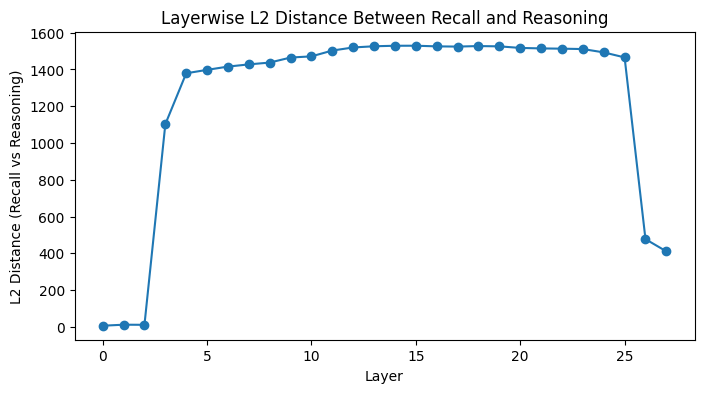

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

l2s = [layer_differences[i]['l2_distance'] for i in range(len(layer_differences))]
plt.figure(figsize=(8,4))
plt.plot(l2s, marker='o')
plt.xlabel("Layer")
plt.ylabel("L2 Distance (Recall vs Reasoning)")
plt.title("Layerwise L2 Distance Between Recall and Reasoning")
plt.show()

Observations:


*   Layers 0–2: L2 distance is very low (almost zero).
*   Layers 3–4: L2 distance jumps up sharply
*   Layers 5–25: L2 distance remains very high and relatively flat (around 1400–1550)
*   Layers 26–27: L2 distance drops sharply again.

Analysis:
* Early layers (0–2): The model processes recall and reasoning prompts similarly—these layers are likely just encoding the input.
* Middle layers (3–25): The model’s internal representations for recall and reasoning diverge dramatically. This is where the model is “deciding” and processing the two types of tasks differently.
* Final layers (26–27): The representations converge again, possibly as the model prepares to generate output tokens.

**Insight**:
Layers 3–25 are the “decision layers” where the model’s internal state is most different for recall vs. reasoning.





**Cosine Distance measures the direction of difference and useful to understand if model uses different logic. High value means different features or concepts are used**

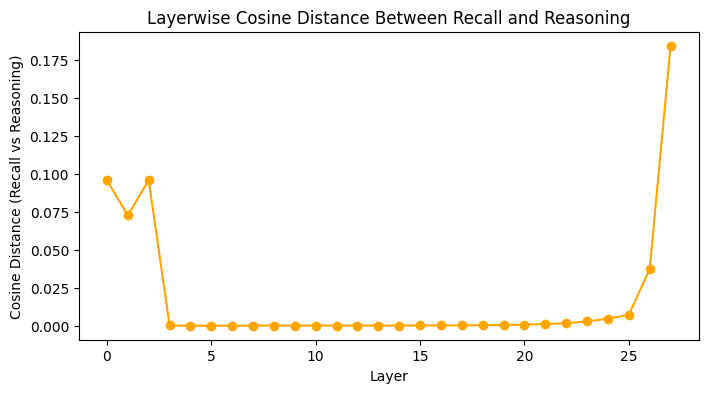

In [ ]:
cosines = [layer_differences[i]['cosine_distance'] for i in range(len(layer_differences))]
plt.figure(figsize=(8,4))
plt.plot(cosines, marker='o', color='orange')
plt.xlabel("Layer")
plt.ylabel("Cosine Distance (Recall vs Reasoning)")
plt.title("Layerwise Cosine Distance Between Recall and Reasoning")
plt.show()

Observations:

*   Layers 0–2: Cosine distance is moderate (~0.1), indicating some directional difference between recall and reasoning.
*   Layers 3–25: Cosine distance drops to nearly zero and stays flat
*   Layers 25–27: Cosine distance rises sharply, peaking at the final layer.

Analysis:
* Early layers (0–2): The model starts to differentiate recall and reasoning in the direction of its activations, but not strongly.
* Middle layers (3–25): The direction of the mean activation vectors for recall and reasoning is almost identical (cosine distance ≈ 0), even though the magnitude (L2 distance) is very large (as seen in your previous plot).
This means the model is using the same “features” or subspace for both tasks, but the amount of activation in those features is different.
* Final layers (26–27): The direction diverges again, especially in the very last layer. This could indicate that the model is preparing to generate different types of outputs for recall vs. reasoning, or that the output head is more sensitive to the task type.

**Insight**:
The sharp rise in cosine distance at the end suggests the model “decides” on the output type (recall vs. reasoning) right before generating text.

**P-value measures statistical significance and useful for confirming real, non-noisy effect. High value means difference is reliable and not random**

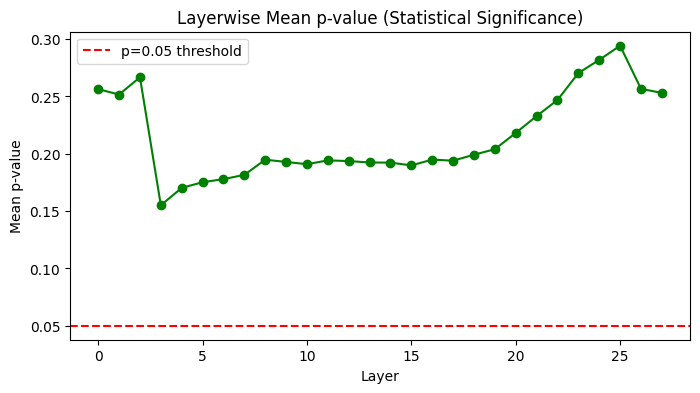

In [ ]:
mean_pvals = [np.mean(layer_differences[i]['p_value']) for i in range(len(layer_differences))]
plt.figure(figsize=(8,4))
plt.plot(mean_pvals, marker='o', color='green')
plt.axhline(0.05, color='red', linestyle='--', label='p=0.05 threshold')
plt.xlabel("Layer")
plt.ylabel("Mean p-value")
plt.title("Layerwise Mean p-value (Statistical Significance)")
plt.legend()
plt.show()

Observations:

* All layers have mean p-values well above 0.05 (the red dashed line).
* There is a dip at layer 4, but still above 0.05.
* p-values rise in the later layers (20–25).

Analysis:
* No layer shows a statistically significant difference (on average, across all dimensions) between recall and reasoning activations.
* This could be due to:
  * Small sample size (few prompts per class).
  * High variance in activations.
  * The difference is spread across many dimensions, but not concentrated enough in any one to be statistically significant.

**Insight**:
* While the magnitude of difference (L2) is large, the statistical significance (p-value) is not strong.
* This suggests the difference is distributed across many features, but not focused in a few.

**Assessment of Disentanglement Metrics:**

The analysis of L2 distance, cosine distance, and mean p-value across layers reveals a clear mechanistic pattern in how the model distinguishes between recall and reasoning tasks. In the early layers (0–2), there is little difference between the two task types, indicating shared input encoding. In the middle layers (3–24), the L2 distance between recall and reasoning activations is very high while the cosine distance is near zero, suggesting that the model uses the same set of features for both tasks but activates them to different extents. The mean p-value remains high throughout, indicating that the difference is distributed across many dimensions rather than concentrated in a few. In the final layers (25–27), the L2 distance drops and the cosine distance rises sharply, implying that the model shifts the direction of its activations to prepare for different output types. Overall, the model’s disentanglement of recall and reasoning is primarily achieved through changes in activation magnitude in the middle layers and a directional shift in the final layers, rather than through distinct features or statistically significant changes in a small subset of dimensions.

# Controlled experiment to validate the above process by checking the layer differences b/w recall prompt 1 and recall prompt 2

In [ ]:
prompts = [
    ("recall1", "What is the capital of France?"),
    ("recall2", "What is the capital of Germany?")
]

In [ ]:
collected_data = collect_activations(model, prompts)

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

In [ ]:
recall1_data = [item for item in collected_data if item['label'] == 'recall1']
recall2_data = [item for item in collected_data if item['label'] == 'recall2']

In [ ]:
print(recall1_data)

[{'label': 'recall1', 'prompt': 'What is the capital of France?', 'generated': ' The capital of France is Paris. \n\nParis is', 'activations': [tensor([[[-0.3711,  0.6719, -0.2256,  ...,  0.1235,  0.2832, -0.4844],
         [ 0.1406, -0.3281,  0.4668,  ...,  0.0835, -0.2100, -0.1777],
         [-0.0620,  0.0035,  0.2178,  ...,  0.1416, -0.0693,  0.2031],
         ...,
         [-0.1934,  0.1816,  0.0996,  ...,  0.0605, -0.1094, -0.0059],
         [ 0.1221,  0.1641,  0.2969,  ..., -0.1079,  0.0605, -0.0300],
         [ 0.0801, -0.0386, -0.0242,  ...,  0.4785, -0.0190, -0.0508]]],
       device='cuda:0', dtype=torch.bfloat16), tensor([[[-0.2021,  0.4043, -0.3789,  ..., -0.0752,  0.2256, -0.7656],
         [ 0.1309, -0.6328,  0.4219,  ...,  0.0640,  0.0420, -0.3105],
         [ 0.0388, -0.2490, -0.0605,  ...,  0.2520,  0.0601,  0.1523],
         ...,
         [-0.1406,  0.1924, -0.0034,  ..., -0.0415, -0.0391, -0.2354],
         [ 0.3750,  0.4043,  0.2041,  ..., -0.3164, -0.2539, -0.3359]

In [ ]:
print(recall2_data)

[{'label': 'recall2', 'prompt': 'What is the capital of Germany?', 'generated': ' The capital of Germany is Berlin. \n\nBerlin is', 'activations': [tensor([[[-0.3711,  0.6719, -0.2256,  ...,  0.1235,  0.2832, -0.4844],
         [ 0.1406, -0.3281,  0.4668,  ...,  0.0835, -0.2100, -0.1777],
         [-0.0620,  0.0035,  0.2178,  ...,  0.1416, -0.0693,  0.2031],
         ...,
         [-0.1934,  0.1816,  0.0996,  ...,  0.0605, -0.1094, -0.0059],
         [ 0.1543,  0.1875,  0.0566,  ...,  0.0122,  0.0430,  0.0078],
         [ 0.0120, -0.0344, -0.0022,  ...,  0.4609, -0.0304, -0.0347]]],
       device='cuda:0', dtype=torch.bfloat16), tensor([[[-0.2021,  0.4043, -0.3789,  ..., -0.0752,  0.2256, -0.7656],
         [ 0.1309, -0.6328,  0.4219,  ...,  0.0640,  0.0420, -0.3105],
         [ 0.0388, -0.2490, -0.0605,  ...,  0.2520,  0.0601,  0.1523],
         ...,
         [-0.1406,  0.1924, -0.0034,  ..., -0.0415, -0.0391, -0.2354],
         [ 0.0864,  0.3086,  0.0312,  ...,  0.1201, -0.0942, -0.1

In [ ]:
def compare_single_prompts(data1, data2):
    num_layers = len(data1[0]['activations'])
    l2s = []
    cosines = []
    for layer_idx in range(num_layers):
        arr1 = data1[0]['activations'][layer_idx].detach().cpu().to(torch.float32).numpy()
        arr2 = data2[0]['activations'][layer_idx].detach().cpu().to(torch.float32).numpy()
        arr1 = np.mean(arr1, axis=(0, 1)) if arr1.ndim == 3 else np.mean(arr1, axis=0)
        arr2 = np.mean(arr2, axis=(0, 1)) if arr2.ndim == 3 else np.mean(arr2, axis=0)
        l2 = np.linalg.norm(arr2 - arr1)
        cosine = 1 - np.dot(arr1, arr2) / (np.linalg.norm(arr1) * np.linalg.norm(arr2))
        l2s.append(l2)
        cosines.append(cosine)
    return l2s, cosines

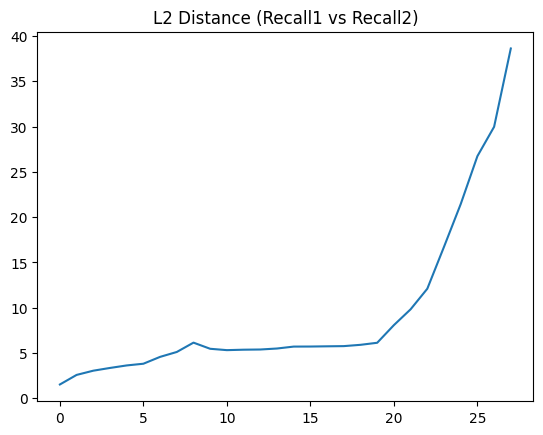

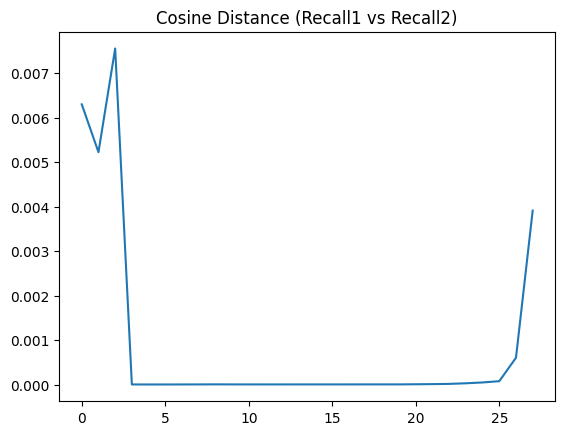

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

l2s, cosines = compare_single_prompts(recall1_data, recall2_data)
plt.plot(l2s); plt.title("L2 Distance (Recall1 vs Recall2)"); plt.show()
plt.plot(cosines); plt.title("Cosine Distance (Recall1 vs Recall2)"); plt.show()

In [ ]:
print(tokenizer("What is the capital of France?")["input_ids"])
print(tokenizer("What is the capital of Germany?")["input_ids"])

[3838, 374, 279, 6722, 315, 9625, 30]
[3838, 374, 279, 6722, 315, 9856, 30]


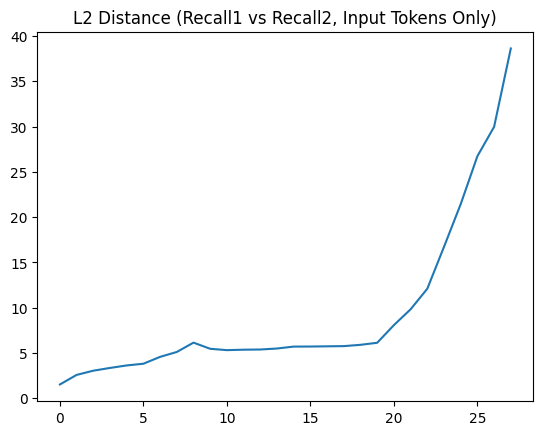

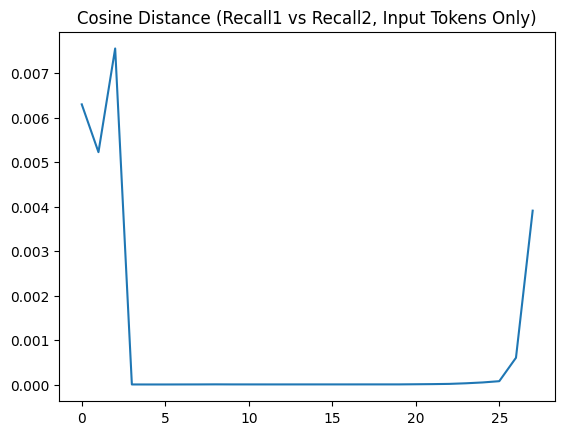

In [ ]:
def get_mean_input_activations(item, input_len):
    # item['activations'] is a list of tensors, one per layer
    means = []
    for layer_act in item['activations']:
        arr = layer_act.detach().cpu().to(torch.float32).numpy()
        # arr shape: (batch, seq, hidden)
        arr = arr[:, :input_len, :]  # Only input tokens
        arr = np.mean(arr, axis=(0, 1))  # Mean over batch and input tokens
        means.append(arr)
    return means

# Get input length (should be the same for both)
input_len = len(tokenizer("What is the capital of France?")["input_ids"])

recall1_means = get_mean_input_activations(recall1_data[0], input_len)
recall2_means = get_mean_input_activations(recall2_data[0], input_len)

l2s = [np.linalg.norm(r2 - r1) for r1, r2 in zip(recall1_means, recall2_means)]
cosines = [1 - np.dot(r1, r2) / (np.linalg.norm(r1) * np.linalg.norm(r2)) for r1, r2 in zip(recall1_means, recall2_means)]

import matplotlib.pyplot as plt
plt.plot(l2s)
plt.title("L2 Distance (Recall1 vs Recall2, Input Tokens Only)")
plt.show()

plt.plot(cosines)
plt.title("Cosine Distance (Recall1 vs Recall2, Input Tokens Only)")
plt.show()

Per-Dimension Difference Analysis Across All Layers


In [ ]:
import numpy as np

def per_dimension_difference_across_layers(means1, means2, top_k=5):
    """
    For each layer, print the top-k most differing dimensions (by absolute value)
    between two mean activation lists (means1, means2).
    """
    num_layers = len(means1)
    for layer_idx in range(num_layers):
        diff = means1[layer_idx] - means2[layer_idx]
        top_indices = np.argsort(np.abs(diff))[-top_k:]
        print(f"\nLayer {layer_idx}:")
        print("  Top differing dimensions:", top_indices)
        print("  Differences:", diff[top_indices])
        print("  Max abs diff:", np.max(np.abs(diff)))
        print("  Mean abs diff:", np.mean(np.abs(diff)))
        print("  Std abs diff:", np.std(np.abs(diff)))

# Example usage:
# recall1_means and recall2_means should be lists of mean vectors, one per layer
per_dimension_difference_across_layers(recall1_means, recall2_means, top_k=5)


Layer 0:
  Top differing dimensions: [3524 2445 3290 3157 2477]
  Differences: [-0.17759487 -0.17989676  0.18711634  0.20200892 -0.21512273]
  Max abs diff: 0.21512273
  Mean abs diff: 0.01858727
  Std abs diff: 0.017473072

Layer 1:
  Top differing dimensions: [3524 3290 3157 2477 2467]
  Differences: [-0.24944197  0.27448383  0.32310268 -0.34654018  0.38671875]
  Max abs diff: 0.38671875
  Mean abs diff: 0.0316027
  Std abs diff: 0.02935974

Layer 2:
  Top differing dimensions: [  46 3524 2477 3157 2467]
  Differences: [-0.32986888 -0.3738839  -0.375279    0.37667412  0.408517  ]
  Max abs diff: 0.408517
  Mean abs diff: 0.03684347
  Std abs diff: 0.035186015

Layer 3:
  Top differing dimensions: [  46 3524 3157 2477 2467]
  Differences: [-0.38448662 -0.39648438  0.42801338 -0.43973213  0.44545197]
  Max abs diff: 0.44545197
  Mean abs diff: 0.040097866
  Std abs diff: 0.039090082

Layer 4:
  Top differing dimensions: [3290 2467 3524 2477 3157]
  Differences: [ 0.46819192  0.5007673

In [ ]:
recall1_data[0]['activations'][1][0].shape

torch.Size([7, 3584])

In [ ]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 3584)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=3584, out_features=3584, bias=True)
          (k_proj): Linear(in_features=3584, out_features=512, bias=True)
          (v_proj): Linear(in_features=3584, out_features=512, bias=True)
          (o_proj): Linear(in_features=3584, out_features=3584, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=3584, out_features=18944, bias=False)
          (up_proj): Linear(in_features=3584, out_features=18944, bias=False)
          (down_proj): Linear(in_features=18944, out_features=3584, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
      )
    )
    (norm):

In [ ]:
import torch

def collect_activations_with_logits(model, prompts, n_new_tokens=10, top_k=5):
    collected_data = []

    for label, prompt in prompts:
        probs_layers = []
        with model.generate(prompt, max_new_tokens=n_new_tokens) as tracer:
            out = model.generator.output.save()
            saved_acts = []
            for i in range(model.config.num_hidden_layers):
                layer_output = model.model.layers[i].output.save()
                saved_acts.append(layer_output)

                # Apply softmax to obtain probabilities and save the result
                probs = torch.nn.functional.softmax(layer_output[0], dim=-1).save()
                probs_layers.append(probs)


        # After the context, extract the actual tensors from the proxies
        layer_activations = []
        for act in saved_acts:
            value = act.value
            if isinstance(value, tuple):
                value = value[0]
            layer_activations.append(value)

        # Logit lens: process activations outside the context!
        logit_lens = []
        for i in range(len(layer_activations)):
            value = layer_activations[i]
            normed = model.model.norm(value)
            logits = model.lm_head(normed)
            probs = torch.nn.functional.softmax(logits, dim=-1)
            top_probs, top_indices = probs.topk(top_k, dim=-1)
            logit_lens.append({
                "top_probs": top_probs.detach().cpu(),
                "top_indices": top_indices.detach().cpu()
            })

        # Decode prompt and generated text
        decoded_prompt = model.tokenizer.decode(out[0][0:-n_new_tokens].cpu())
        decoded_answer = model.tokenizer.decode(out[0][-n_new_tokens:].cpu())

        probs = torch.cat([probs.value for probs in probs_layers])

        # Find the maximum probability and corresponding tokens for each position
        max_probs, tokens = probs.max(dim=-1)

        # Decode token IDs to words for each layer
        words = [[model.tokenizer.decode(t.cpu()).encode("unicode_escape").decode() for t in layer_tokens]
    for layer_tokens in tokens]

        # Decode top tokens for each layer and each token position
        decoded_top_tokens = []
        for layer in logit_lens:
            layer_tokens = []
            for token_pos in range(layer["top_indices"].shape[1]):
                tokens = [model.tokenizer.decode([idx]) for idx in layer["top_indices"][0, token_pos]]
                layer_tokens.append(tokens)
            decoded_top_tokens.append(layer_tokens)

         # Get input words
        input_ids = out[0][0:-n_new_tokens].cpu()  # Only input tokens
        input_words = [clean_token(model.tokenizer.decode([tid])) for tid in input_ids]

        collected_data.append({
            'label': label,
            'prompt': decoded_prompt,
            'generated': decoded_answer,
            'activations': layer_activations,
            'logit_lens': logit_lens,
            'decoded_top_tokens': decoded_top_tokens,
            'input_words': input_words,
            'words': words,
            'max_probs': max_probs
        })

    return collected_data

collected_data = collect_activations_with_logits(model, prompts)

In [ ]:
collected_data[0]['max_probs']

tensor([[0.1455, 0.0063, 0.0175, 0.0025, 0.0016, 0.0035, 0.0033],
        [0.7422, 0.0172, 0.1455, 0.0154, 0.0029, 0.0106, 0.0073],
        [0.2598, 0.1021, 0.1064, 0.1074, 0.0096, 0.0165, 0.0074],
        [1.0000, 0.2207, 0.3086, 0.1445, 0.0139, 0.0256, 0.0117],
        [1.0000, 0.3203, 0.4160, 0.0791, 0.0098, 0.0554, 0.0237],
        [1.0000, 0.2617, 0.4531, 0.0771, 0.0259, 0.1226, 0.0493],
        [1.0000, 0.2812, 0.7422, 0.0615, 0.0254, 0.2695, 0.0845],
        [1.0000, 0.7305, 0.9766, 0.1050, 0.0452, 0.4902, 0.1357],
        [1.0000, 0.7852, 0.9844, 0.0796, 0.1089, 0.5781, 0.2266],
        [1.0000, 0.5117, 0.9414, 0.0986, 0.1572, 0.7031, 0.4043],
        [1.0000, 0.4277, 0.9453, 0.1592, 0.1562, 0.7930, 0.6641],
        [1.0000, 0.4727, 0.9727, 0.3242, 0.2275, 0.8398, 0.7500],
        [1.0000, 0.4980, 0.9805, 0.2969, 0.2559, 0.8828, 0.8125],
        [1.0000, 0.7969, 0.9688, 0.4746, 0.2598, 0.8750, 0.8945],
        [1.0000, 0.8438, 0.9648, 0.5234, 0.2969, 0.8633, 0.9336],
        [1

In [ ]:
prompts

[('recall1', 'What is the capital of France?'),
 ('recall2', 'What is the capital of Germany?')]

In [ ]:
collected_data[0]['activations']

[tensor([[[-0.3711,  0.6719, -0.2256,  ...,  0.1235,  0.2832, -0.4844],
          [ 0.1406, -0.3281,  0.4668,  ...,  0.0835, -0.2100, -0.1777],
          [-0.0620,  0.0035,  0.2178,  ...,  0.1416, -0.0693,  0.2031],
          ...,
          [-0.1934,  0.1816,  0.0996,  ...,  0.0605, -0.1094, -0.0059],
          [ 0.1221,  0.1641,  0.2969,  ..., -0.1079,  0.0605, -0.0300],
          [ 0.0801, -0.0386, -0.0242,  ...,  0.4785, -0.0190, -0.0508]]],
        device='cuda:0', dtype=torch.bfloat16),
 tensor([[[-0.2021,  0.4043, -0.3789,  ..., -0.0752,  0.2256, -0.7656],
          [ 0.1309, -0.6328,  0.4219,  ...,  0.0640,  0.0420, -0.3105],
          [ 0.0388, -0.2490, -0.0605,  ...,  0.2520,  0.0601,  0.1523],
          ...,
          [-0.1406,  0.1924, -0.0034,  ..., -0.0415, -0.0391, -0.2354],
          [ 0.3750,  0.4043,  0.2041,  ..., -0.3164, -0.2539, -0.3359],
          [-0.0898, -0.1055, -0.1235,  ...,  0.4922,  0.0046, -0.0432]]],
        device='cuda:0', dtype=torch.bfloat16),
 tenso

In [ ]:
collected_data[0]['words']

[['indows', 'indows', 'indows', ' next', ' next', 'indows', 'alk'],
 ['indows', '5', 'indows', '5', ' next', 'indows', 'alk'],
 [';\\r\\n\\r\\n', '5', 'indows', '5', '5', 'indows', '5'],
 ['ling', '5', ' >=', '5', '5', 'indows', ' /'],
 ['ling', '5', ' >=', '5', '5', 'indows', ' /'],
 ['ling', '5', ' >=', '5', '5', 'indows', ' /'],
 ['ling', ' >=', ' >=', ' fil', '(n', 'indows', ' /'],
 ['ling', ' >=', ' >=', ' fil', '(n', 'indows', ' /'],
 ['ling', ' >=', ' >=', ' fil', '(n', 'indows', ' /'],
 ['ling', ' >=', ' >=', 'Start', '(n', 'indows', ' /'],
 ['ling', ' >=', ' >=', ' fil', '(n', 'indows', ' /'],
 ['ling', ' /', ' >=', ' fil', '(n', 'indows', ' /'],
 ['ling', ' /', ' >=', ' fil', '(n', 'indows', ' /'],
 ['ling', ' /', ' >=', ' fil', '(n', 'indows', ' /'],
 ['ling', ' /', ' >=', ' fil', ' men', 'indows', ' /'],
 ['ling', ' /', ' >=', ' fil', ' men', 'indows', ' /'],
 ['ling', ' /', ' >=', ' fil', ' men', 'indows', ' /'],
 ['ling', ' /', ' >=', ' fil', ' men', 'indows', ' /'],
 ['l

In [ ]:
import plotly.express as px
import plotly.io as pio

is_colab = True
if is_colab:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "plotly_mimetype+notebook_connected+notebook"

sample = collected_data[0]
max_probs = sample['max_probs'].to(torch.float32)
fig = px.imshow(
    max_probs.detach().cpu().numpy(),
    x=sample['input_words'],
    y=list(range(len(sample['words']))),
    color_continuous_scale=px.colors.diverging.RdYlBu_r,
    color_continuous_midpoint=0.50,
    text_auto=True,
    labels=dict(x="Input Tokens", y="Layers", color="Probability")
)

fig.update_layout(
    title='Logit Lens Visualization',
    xaxis_tickangle=0
)

fig.update_traces(text=sample['words'], texttemplate="%{text}")
fig.show()